In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from datetime import datetime as dt


In [2]:
data = pd.read_parquet(r'C:\Data\Citibike_NY_2022\merged\bikes_weather_data.parquet')

In [3]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,date,AWND,PRCP,TAVG,_merge
337365,FB33E3D8F21E2941,electric_bike,2022-01-01 01:49:37.374,2022-01-01 01:57:50.346,Canal St & Rutgers St,5303.08,Norfolk St & Broome St,5374.01,40.714275,-73.989900,40.717227,-73.988021,casual,2022-01-01,28,193,116,both
934147,755337295F178067,electric_bike,2022-01-01 03:21:09.754,2022-01-01 03:49:33.047,Lewis Ave & Madison St,4425.02,Columbia St & Degraw St,4422.04,40.686312,-73.935775,40.685930,-74.002424,member,2022-01-01,28,193,116,both
227118,C62CA87E3A475ADD,classic_bike,2022-01-01 08:38:18.156,2022-01-01 08:47:54.213,Carlton Ave & Park Ave,4732.04,Emerson Pl & Myrtle Ave,4683.02,40.695807,-73.973556,40.693631,-73.962236,casual,2022-01-01,28,193,116,both
913138,CD7A2098AFCD5514,classic_bike,2022-01-01 10:33:58.529,2022-01-01 10:47:05.197,W 100 St & Broadway,7580.01,W 67 St & Broadway,7116.04,40.797372,-73.970412,40.774925,-73.982666,casual,2022-01-01,28,193,116,both
127328,3F9E0C51F49F78A3,electric_bike,2022-01-01 20:05:19.592,2022-01-01 20:12:00.661,W 18 St & 6 Ave,6064.08,W 42 St & 6 Ave,6517.08,40.739713,-73.994564,40.754920,-73.984550,member,2022-01-01,28,193,116,both


In [4]:
data.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
date                          object
AWND                           int64
PRCP                           int64
TAVG                           int64
_merge                      category
dtype: object

In [5]:
data['date'] = pd.to_datetime(data['date'])

In [6]:
# Checking all dates have same weather values 
check = (
    data.groupby('date')[['TAVG', 'PRCP', 'AWND']]
    .nunique()
)

inconsistent = check[(check > 1).any(axis=1)]
print(inconsistent)

Empty DataFrame
Columns: [TAVG, PRCP, AWND]
Index: []


In [114]:
# Creating grouped df where each row is a day with number of trips aggregated - avoids millions of rows unnecessarily
    # Keeping all three weather variables and renaming them
df = ( data.groupby('date')
      .agg(
          trip_count = ('date', 'size'),
          temperature = ('TAVG', 'first'),
          precipitation = ('PRCP', 'first'),
          wind = ('AWND', 'first')
      )
          .reset_index()
          .copy()
)

In [115]:
df.head()

,date,trip_count,temperature,precipitation,wind
0,2022-01-01,20428,116,193,28
1,2022-01-02,43009,114,10,43
2,2022-01-03,33189,14,0,64
3,2022-01-04,36842,-27,0,39
4,2022-01-05,34230,32,61,34


In [116]:
# Making date the index
df.set_index('date', inplace=True)

In [117]:
df.describe()

,trip_count,temperature,precipitation,wind
count,365.000000,365.000000,365.000000,365.000000
mean,81748.400000,137.808219,30.789041,47.838356
std,33195.818419,97.416075,68.075200,17.341073
min,2848.000000,-117.000000,0.000000,17.000000
25%,54110.000000,59.000000,0.000000,35.000000
50%,87089.000000,139.000000,0.000000,44.000000
75%,111846.000000,221.000000,20.000000,56.000000
max,135072.000000,313.000000,450.000000,109.000000


In [ ]:
# converting temperature to ° Celsius since easier to interpret (currently in tenths of degrees C)
# see for full details https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt
df['temperature'] = df['temperature']/10
df['temperature'].describe()

count    365.000000
mean      13.780822
std        9.741608
min      -11.700000
25%        5.900000
50%       13.900000
75%       22.100000
max       31.300000
Name: temperature, dtype: float64

<Axes: xlabel='date'>

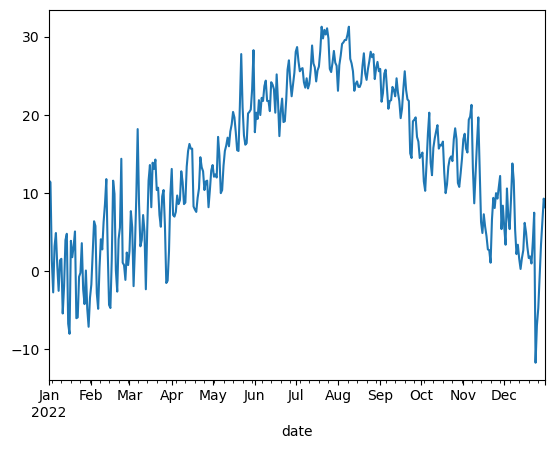

In [22]:
# Making basic pandas plot with temperature over time
df['temperature'].plot()

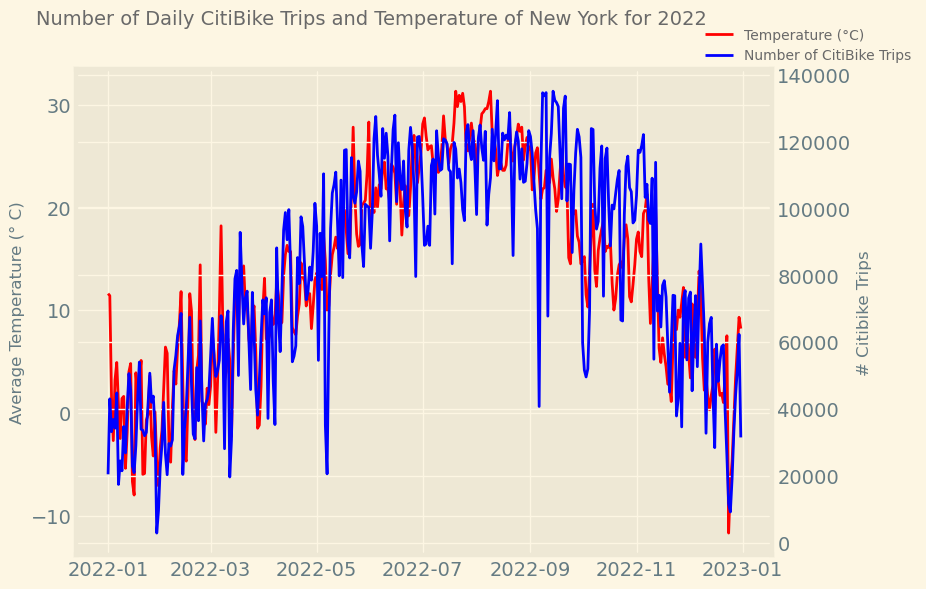

In [52]:
# Plotting temperature and number of trips on dual axis
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots(figsize=(8,6))

# temperature plot
l_temp = ax.plot(df['temperature'],
        color = 'red',
        label = 'Temperature (°C)')

# create dual axis
ax2 = ax.twinx()

# plot number of bikerides
l_trips = ax2.plot(df['trip_count'],
         color = 'blue',
         label = 'Number of CitiBike Trips')

ax.set_ylabel('Average Temperature (° C)')
ax2.set_ylabel('# Citibike Trips')

# Making title above plot and legend
fig.suptitle(
    "Number of Daily CitiBike Trips and Temperature of New York for 2022",
    color='dimgray', fontsize=14, x=0.03, y=0.98, ha='left'
)
# Combine both lines for legend
lines = l_temp + l_trips
labels = [line.get_label() for line in lines]

fig.legend(
    handles=lines,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(0.85, 0.92),
    frameon=False,
    fontsize=10,
    labelcolor='dimgray'
)

plt.show()

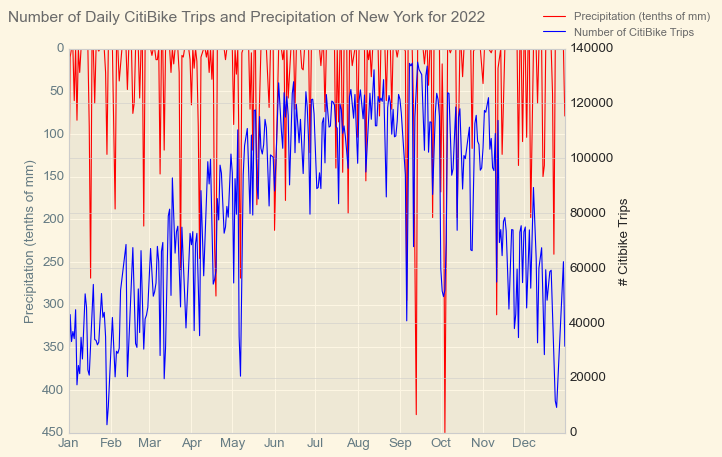

In [123]:
# Plotting rain and number of trips on dual axis, with precipitation inverted
import matplotlib.dates as mdates

with plt.style.context('Solarize_Light2'):

    fig, ax = plt.subplots(figsize=(8,6))

# percipitation plot
l_prec = ax.plot(df['precipitation'],
        color = 'red',
        label = 'Precipitation (tenths of mm)')
ax.invert_yaxis()

# create dual axis
ax2 = ax.twinx()

# plot number of bikerides
l_trips = ax2.plot(df['trip_count'],
         color = 'blue',
         label = 'Number of CitiBike Trips')

ax.set_ylabel('Precipitation (tenths of mm)')
ax2.set_ylabel('# Citibike Trips')

# Making title above plot and legend
fig.suptitle(
    "Number of Daily CitiBike Trips and Precipitation of New York for 2022",
    color='dimgray', fontsize=14, x=0.03, y=0.98, ha='left'
)
# Combine both lines for legend
lines = l_prec + l_trips
labels = [line.get_label() for line in lines]

fig.legend(
    handles=lines,
    labels=labels,
    loc='center left',
    bbox_to_anchor=(0.85, 0.95),
    frameon=False,
    fontsize=10,
    labelcolor='dimgray'
)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.show()

Trip duration histogram

In [54]:
# calculating trip duration
ns = data['ended_at'] - data['started_at']
ns.head()

337365   0 days 00:08:12.972000
934147   0 days 00:28:23.293000
227118   0 days 00:09:36.057000
913138   0 days 00:13:06.668000
127328   0 days 00:06:41.069000
dtype: timedelta64[ns]

In [60]:
seconds = ns.dt.total_seconds()
seconds.head()

337365     492.972
934147    1703.293
227118     576.057
913138     786.668
127328     401.069
dtype: float64

In [80]:
minutes = ns.dt.total_seconds() / 60
minutes.head()

337365     8.216200
934147    28.388217
227118     9.600950
913138    13.111133
127328     6.684483
dtype: float64

In [81]:
minutes.describe()

count    2.983817e+07
mean     1.820962e+01
std      2.614485e+02
min     -5.728892e+01
25%      5.796733e+00
50%      1.016200e+01
75%      1.799900e+01
max      4.044810e+05
dtype: float64

In [82]:
# removing any trips with negative values
minutes = minutes[minutes >= 0].copy()

In [83]:
threshold = 100

outliers = minutes[minutes > threshold]
print(f"Number of rentals longer than 100 minutes:", outliers.count())

Number of rentals longer than 100 minutes: 219010


In [84]:
data.shape

(29838166, 18)

In [85]:
(219010*100)/29838166

0.7339928332056334

In [90]:
# Removing trips longer than a day (0.73% of trips)
mins = minutes[minutes < threshold].copy()
mins.shape

(29618799,)

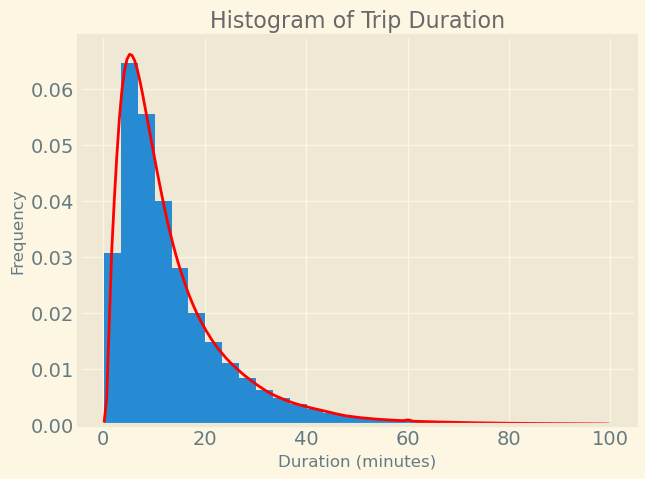

In [ ]:
from scipy.stats import gaussian_kde

# histogram
mins.plot.hist(bins=30,
              density=True) # so the scales work together 

# KDE estimation
kde = gaussian_kde(mins)
x_vals = np.linspace(mins.min(), mins.max(), 200)
kde_vals = kde(x_vals)

# Plot KDE curve
plt.plot(x_vals, kde_vals, color='red', lw=2)

plt.xlabel('Duration (minutes)')
plt.title('Histogram of Trip Duration',color='dimgrey')
plt.show()

Plotting rides by usertype and rideable type

In [96]:
# Count the categories of both variables
member_counts = data['member_casual'].value_counts()
rideable_counts = data['rideable_type'].value_counts()

In [98]:
member_counts

member_casual
member    23257501
casual     6580665
Name: count, dtype: int64

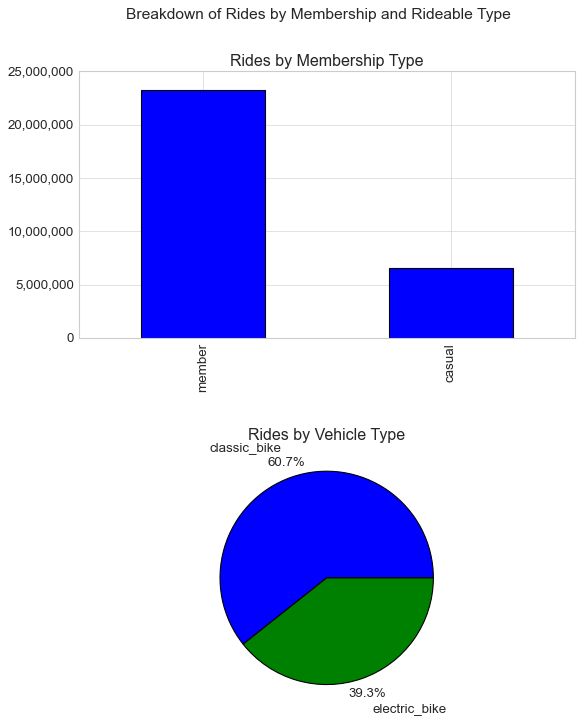

In [113]:
plt.style.use('seaborn-v0_8-whitegrid')
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(2, 1, figsize = (8,10))

member_counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Rides by Membership Type')
ax[0].set_xlabel('')  
ax[0].set_ylabel('')  
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))


rideable_counts.plot(kind='pie', ax=ax[1], autopct='%1.1f%%',
                     pctdistance=1.15, labeldistance=1.3)    # moving % out of pie
ax[1].set_title('Rides by Vehicle Type')
ax[1].set_xlabel('')  
ax[1].set_ylabel('') 

plt.suptitle('Breakdown of Rides by Membership and Rideable Type',
             fontsize=14)

plt.subplots_adjust(hspace=0.4) # adding space between plots

plt.show()